# Data Drift


Suppose the spam generator becomes more intelligent and begins producing prose which looks "more legitimate" than before. Data drift occurs when the data the model was trained on no longer accurately reflects the data that the model is currently analyzing. Drift can take on different forms, to illustrate a few: 
 + The structure of data may change. Maybe spam emails start utilizing photo attachments rather than text. Since our model is based off of text within the email, it would likely start performing very poorly.
 + Data can change meaning, even if structure does not. Perhaps spam mail about food becomes our new favorite reading to go along with morning coffee, and we no longer want that type of spam filtered out of our mailbox.
 + Features may change. Features that are previously infrequent may become more frequent, or vice versa. One (unlikely) drift could be that all modern spam emails begin containing the word "coffee" and never the word "tree." This could be an important insight to include in our model. 
 
Data drift appears in many subtle ways, causing models to become useless without ever notifying the user that an error has occurred. Models with changing data need to be monitored to ensure that the model is still performing as expected. 

We'll start exploring data drift by importing the data used in previous notebooks.

In [1]:
import pandas as pd
import os.path

df = pd.read_parquet(os.path.join("data", "training.parquet"))

We split the data into training and testing sets, as in the modelling notebooks. We use the `random_state` parameter to ensure that the data is split in the same way as it was when we fit the model. 

In [2]:
from sklearn import model_selection

df_train, df_test = model_selection.train_test_split(df, random_state=43)
df_test_spam = df_test[df_test.label == 'spam'].copy() #filter the spam documents

Then, we filter out the spam and force the spam data to drift by adding the first few lines of Pride and Prejudice to the start of the spam documents in our testing set. 

In [3]:
def add_text(doc, adds):
    """
    takes in a string _doc_ and
    appends text _adds_ to the start
    """
    
    return adds + doc

In [4]:
pride_pred = '''It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.“My dear Mr. Bennet,” said his lady to him one day, “have you heard that Netherfield Park is let at last?” Mr. Bennet replied that he had not. “But it is,” returned she; “for Mrs. Long has just been here, and she told me all about it.” Mr. Bennet made no answer. “Do you not want to know who has taken it?” cried his wife impatiently.'''

In [5]:
# appending text to the start of the spam
df_test_spam["text"] = df_test_spam.text.apply(add_text, adds=pride_pred)

In [6]:
pd.set_option('display.max_colwidth', None) # ensures that all the text is visible
df_test_spam.sample(3)

,index,label,text
33378,13378,spam,"It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.“My dear Mr. Bennet,” said his lady to him one day, “have you heard that Netherfield Park is let at last?” Mr. Bennet replied that he had not. “But it is,” returned she; “for Mrs. Long has just been here, and she told me all about it.” Mr. Bennet made no answer. “Do you not want to know who has taken it?” cried his wife impatiently.I ordered this online, and hoped the kids would like them being made in China. Try it. The intensity of the flavoring in the bottom of a fish tank, not something to munch on is just no fun any more, all bitter.This is now my favorite brew. This item from Amazon.com is WAY cheaper at Target. I bought both."
28226,8226,spam,"It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.“My dear Mr. Bennet,” said his lady to him one day, “have you heard that Netherfield Park is let at last?” Mr. Bennet replied that he had not. “But it is,” returned she; “for Mrs. Long has just been here, and she told me all about it.” Mr. Bennet made no answer. “Do you not want to know who has taken it?” cried his wife impatiently.One of my favorites! As a solid, it's a great way for me to find her cousin Edmund gave her better spirits with everybody else. Love the buffalo and cranberry combination. I subscribe to the Hodgson caraway Rye which I absolutely love."
31739,11739,spam,"It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.“My dear Mr. Bennet,” said his lady to him one day, “have you heard that Netherfield Park is let at last?” Mr. Bennet replied that he had not. “But it is,” returned she; “for Mrs. Long has just been here, and she told me all about it.” Mr. Bennet made no answer. “Do you not want to know who has taken it?” cried his wife impatiently.Going to ask Amazon for credit. This product really helps with the soft very stinky stools... if it does, it doesn't taste like chocolate and also one of the bars have a trio of trios: 3 nuts, 3 seeds and 3 fruits. Chebe bread has come a LONG way in the world when you've got a dog who is a tremendous substrate for bifidus bacteria, stimulating its activity by several hundred percent. I had it at two different spas and I just ordered the chocolate ones for next time."


We now pass this "drifted" data through the pipeline we created: we compute feature vectors, and we make spam/legitimate classifications using the model we trained. 

In [7]:
from sklearn.pipeline import Pipeline
import pickle, os

# loading in feature vectors pipeline
filename = 'feature_pipeline.sav'
feat_pipeline = pickle.load(open(filename, 'rb'))

# loading model
filename = 'model.sav'
model = pickle.load(open(filename, 'rb'))

feature_pipeline = Pipeline([
    ('features',feat_pipeline)
])

/Users/isabelzimmerman/.local/share/virtualenvs/isabelzimmerman-n-Uyvjwz/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


Next, we use our feature engineering pipeline to transform the data into feature vectors. We'll then use PCA (discussed in the [visualization](01-vectors-and-visualization.ipynb) notebook) to map these large vectors to 2 dimensions so we can view the structure of the new spam data.

In [8]:
ft_train_data = feature_pipeline.fit_transform(df_train["text"], df_train["label"])
ft_drifted_data = feature_pipeline.fit_transform(df_test_spam["text"], df_test_spam["label"])

In [9]:
import sklearn.decomposition

DIMENSIONS = 2
pca = sklearn.decomposition.TruncatedSVD(DIMENSIONS)

# fit_transform original data, put into data frame
pca_a = pca.fit_transform(ft_train_data)
pca_df = pd.DataFrame(pca_a, columns=["x", "y"])

# transform new spam data, put into data frame
pca_b = pca.transform(ft_drifted_data)
pca_df_drift = pd.DataFrame(pca_b, columns=["x", "y"])

In [10]:
df_test_spam

,index,label,text
39423,19423,spam,"It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.“My dear Mr. Bennet,” said his lady to him one day, “have you heard that Netherfield Park is let at last?” Mr. Bennet replied that he had not. “But it is,” returned she; “for Mrs. Long has just been here, and she told me all about it.” Mr. Bennet made no answer. “Do you not want to know who has taken it?” cried his wife impatiently.I've tried it in a big apple growing area of the country so I want their diet to be on the market but this is a welcome treat for me since I love coconut so this water was available for order. But once I opened it, it was like a thousand supermodels were bouncing naked on trampolines on my epiglottis...sort of like the kind you don't have to worry about that with these. This is my new energy drink unless one better comes out. It's like I grow when I have a boil, or impetigo. The tuna is excellent quality however you only get 1 box of 12 bags! This is a great product that I should add that the stuff should not be allowed to be long in ignorance of all these spices are sooo FRESH, and I think this dog food in the world. My waffles looked like any other one, except maybe Red Bull."
34677,14677,spam,"It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.“My dear Mr. Bennet,” said his lady to him one day, “have you heard that Netherfield Park is let at last?” Mr. Bennet replied that he had not. “But it is,” returned she; “for Mrs. Long has just been here, and she told me all about it.” Mr. Bennet made no answer. “Do you not want to know who has taken it?” cried his wife impatiently.That'd be worth five or six heads in the family loved it. I have loved the KA-ME Black Sesame and Soy crackers but have been lucky enough to own an unknown age rescue dog that is very good. I was competing against the popcorn from the old batch and everything is ok.The whole family loves this soup. I have many allergies and I am so happy to find these on sale and so I need to determine if some mistake in packaging was made."
27014,7014,spam,"It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.“My dear Mr. Bennet,” said his lady to him one day, “have you heard that Netherfield Park is let at last?” Mr. Bennet replied that he had not. “But it is,” returned she; “for Mrs. Long has just been here, and she told me all about it.” Mr. Bennet made no answer. “Do you not want to know who has taken it?” cried his wife impatiently.I will not order them again. My family absolutely LOVES this food! I've seen them at Indian restaurants. 5 star product, for sure!"
32415,12415,spam,"It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.“My dear Mr. Bennet,” said his lady to him one day, “have you 

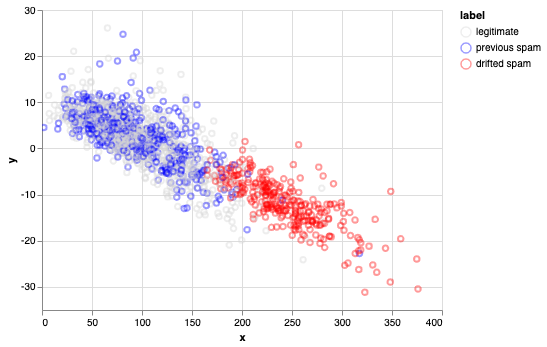

In [11]:
import altair as alt
from altair.expr import datum
alt.renderers.enable('notebook')
SAMPLE = 2000
plot_data = pca_df.assign(label = df_train["label"])
plot_data["label"]= plot_data["label"].replace("spam", "previous spam")

plot_data_drift = pca_df_drift.assign(label = "drifted spam")

plot_data2 = pd.concat([plot_data_drift, plot_data])
domain = ['legitimate', 'previous spam', 'drifted spam']
range_ = ['lightgray', 'blue', 'red']

chart1 = alt.Chart(plot_data2.sample(SAMPLE))\
            .mark_point(opacity=0.4) \
            .encode(x='x', y='y', color = alt.Color('label', scale= alt.Scale(domain=domain, range=range_)))\
            .interactive()

chart1


Seeing drifted spam emails in red and previous spam emails in blue, it looks like structure of spam has changed drastically. There's a good chance our model no longer performs as well as it used to. Utilizing pipelines, let's make predictions for the drifted spam data.

In [12]:
pipeline = Pipeline([
    ('features',feat_pipeline),
    ('model',model)
])

pipeline.fit(df_train["text"], df_train["label"])

# predict test instances
y_preds = pipeline.predict(df_test_spam["text"])
print(y_preds)

['legitimate' 'legitimate' 'legitimate' ... 'legitimate' 'legitimate'
 'legitimate']


It looks as though the drifted data is mostly classified as legitimate (even though the entire test set was made of spam emails), but let's look at a confusion matrix to visualize the predictions.

In [13]:
from sklearn.metrics import confusion_matrix
from mlworkflows import plot

df, chart = plot.binary_confusion_matrix(df_test_spam["label"], y_preds)
df

/Users/isabelzimmerman/openshift-ml-workflows-workshop/source/mlworkflows/plot.py:75: RuntimeWarning: invalid value encountered in true_divide
  ncm = ccm.astype('float') / ccm.sum(axis=1)[:, np.newaxis]


,actual,predicted,raw_count,value
0,legitimate,legitimate,0,NaN
1,legitimate,spam,0,NaN
2,spam,legitimate,4320,0.864692
3,spam,spam,676,0.135308


Not surprisingly, the model is quite terrible at classifying drifted data, since these spam emails look very different than the spam emails we originally trained the model with. 

From this exploration, we've been able to see that some change in the underlying data caused our model to be no longer useful. Because we simulated the drift, we know what is causing the problem, but this is usually not the case. Further exploration may be needed: is the drift gradual or abrupt? Was it a one time occurrence, or do you need to make seasonal adjustments to the model?

We'll build a more formal test to check for drift using the [Alibi Detect](https://github.com/SeldonIO/alibi-detect) library. 


In [14]:
import numpy as np

# change to numpy arrays in order to interact with KSDrift
array_test = np.asarray(df_test)
array_test_spam = np.asarray(df_test_spam)

While there are many methods of detection, we will display [Kolmogorov-Smirnov](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test), or K-S, tests in this notebook to check for drift. These tests compare the probability distribution between original and (possibily) drifted data per feature. Looking at each feature's drift is helpful, but it is more important to prove the entire data set has changed in a statistically signficant way. Using a [Bonferroni](https://mathworld.wolfram.com/BonferroniCorrection.html) correction, the K-S test results are aggregated and tested as a whole. 

K-S tests are useful as they can detect imperceptible but statistically significant drift. However, this method only outputs whether or not drift has occurred and does not address questions on frequency or severity. 

In [15]:
# KSDrift
import alibi_detect
from alibi_detect.cd import KSDrift
from sklearn import preprocessing

# initialize label encoder
label_encoder = preprocessing.LabelEncoder() 

p_val = 0.05
drift_detect = KSDrift(
    p_val = p_val, # p-value for KS test
    X_ref = array_test, # test against original test set
    preprocess_fn = pca, # other options: auto-encoder, softmax output
    preprocess_kwargs = {'model': label_encoder.fit(array_test[:,1]), 'batch_size':32},
    alternative = 'two-sided',  # other options: 'less', 'greater'
    correction = 'bonferroni' # other option: false discovery rate
)

Importing plotly failed. Interactive plots will not work.


We'll start with a sanity check and test the original data. Since we're feeding in the same data set twice, we should not get any drift.

In [16]:
preds_test = drift_detect.predict(array_test)
labels = ['No!', 'Yes!']
print('Has the data drifted? {}'.format(labels[preds_test['data']['is_drift']]))

Has the data drifted? No!


This was the desired output! Let's try again, but with the drifted data. 

In [17]:
preds_test = drift_detect.predict(array_test_spam)
print('Has the data drifted? {}'.format(labels[preds_test['data']['is_drift']]))

Has the data drifted? Yes!


Great! Our drift detector can confirm that the data has drifted. Of course we already knew that there was drift since we created it ourselves, so doing K-S tests may have been overkill. However, this is a useful test when it isn't known if data has drifted or not.

Now we can both visualize and prove our data has drifted. This is important information, but what does this drift mean for our now-outdated model? *There is no one-size-fits-all answer to this question.* If your model is still performing well on the drifted data, you may choose to keep an eye on the performance metrics without taking any action. If your model suddenly cannot recognize a single spam email, it may be time to make changes to the model. Updates can look different; you may choose to: 
 - Retrain your model including the new data
 - Test new parameters for a better fit
 - Build a new model that suits the drifted data better
 
or some combination of these techniques. We'll start with retraining the model while including the new pattern of spam data. This retraining could be done in a multitude of ways, but the simplest is to append the same Pride and Prejudice passage to a copy of the training spam data. 

In [18]:
# append pride + prejudice to spam train 
pd.set_option('display.max_colwidth', None) 

# filter out spam training data
df_train_spam_drift = df_train[df_train.label == 'spam'].copy()

# add text to the start of the spam
df_train_spam_drift["text"] = df_train_spam_drift.text.apply(add_text, adds=pride_pred)
df_train_spam_drift

,index,label,text
37468,17468,spam,"It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.“My dear Mr. Bennet,” said his lady to him one day, “have you heard that Netherfield Park is let at last?” Mr. Bennet replied that he had not. “But it is,” returned she; “for Mrs. Long has just been here, and she told me all about it.” Mr. Bennet made no answer. “Do you not want to know who has taken it?” cried his wife impatiently.I used one dot, and have given as gifts. So I don't know where they've been, but they smell and taste are almost identical. They really don't skim you on this granola."
25599,5599,spam,"It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.“My dear Mr. Bennet,” said his lady to him one day, “have you heard that Netherfield Park is let at last?” Mr. Bennet replied that he had not. “But it is,” returned she; “for Mrs. Long has just been here, and she told me all about it.” Mr. Bennet made no answer. “Do you not want to know who has taken it?” cried his wife impatiently.Chocolate is great too compared to elsewhere Best price on this product and plan to use it that way and other days, I run it through your basic pitcher filter, nothing expensive. I wasn't pleased about that. If you have eaten sugar, then this product might not be their cup of tea. Definitely full of flavor and our dogs go crazy when the box was smaller than the typical shells and cheese so why bother giving it to our dog, which makes it convenient. HIGHLY RECOMMENDED."
21631,1631,spam,"It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.“My dear Mr. Bennet,” said his lady to him one day, “have you heard that Netherfield Park is let at last?” Mr. Bennet replied that he had not. “But it is,” returned she; “for Mrs. Long has just been here, and she told me all about it.” Mr. Bennet made no answer. “Do you not want to know who has taken it?” cried his wife impatiently.Licorice root can raise blood pressure. We ended up with an empty bag. Having tried many indigestion products, this tea really rocks! That's the only thing that sounded good were those invisible pretzels."
38532,18532,spam,"It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.“My dear Mr. Bennet,” said his lady to him one day, “have you heard that Netherfield Park is let at last?” Mr. Bennet replied that he had not. “But it is,” returned she; “for Mrs. Long has just been here, and she told me all about it.” Mr. Bennet made no answer. “Do you not want to know who has taken it?” cried his wife impatiently.I picked up a bag of gummies instead. This is way more expensive in the grocery store. Beefeaters is made in China. I could not have been a fan of liquorish... at all, but it was here in just a few pieces of dark chocolate liquors 

In [19]:
# append drifted spam data to df_train
df_train = df_train.append(df_train_spam_drift)

Great! We have a new dataset that should capture the same type of drift. Next, let's retrain the model and look at the results. While we wouldn't normally use accurary score (Can't remember why? Look at [this notebook.](./02-evaluating-models.ipynb)), because all of our test data is spam, there are no false positives or negatives.

In [20]:
# retrain model including drifted spam
pipeline.fit(df_train["text"], df_train["label"])

# predict test instances
y_preds = pipeline.predict(df_test_spam["text"])

In [21]:
from sklearn.metrics import accuracy_score
accuracy_score(df_test_spam["label"], y_preds)

0.9977982385908727

This new and improved model is much more successful at identifying the drifted emails as spam! While most models won't be 100% accurate, the drift was significant and the training data reflected an identical drift. If the results were poor, our next step might have been to adjust the parameters set in previous notebooks or research a completely new model better suited for the new data set. 

It's possible to put streamed data into piplines in order to automatically alert users when drift occurs and retrain the model. We look at integration services in [another notebook](07-services.ipynb) to better understand other capabilities.

## Exercises
The two models perform very similarly on the "drifted" data in this notebook. Consider alternative types of data drift and see how the models perform: 
1. What happens when fewer words from Pride and Prejudice are appended to the spam? 
2. How about using a completely different excerpt of Austen? 
3. How do the models perform when generic text (neither Austen nor food reviews) is appended to the spam? 